In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from IPython.display import Image
from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model
from spec_extract import Stack
from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'
if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
S_v4 = pd.read_pickle('../dataframes/GS_v4.3_uvj.pkl')
N_v4 = pd.read_pickle('../dataframes/GN_v4.3_uvj.pkl')

S_zg = pd.read_pickle('../dataframes/GS_uvj_z_grism_v2.pkl')
N_zg = pd.read_pickle('../dataframes/GN_uvj_z_grism_v2.pkl')

In [3]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

N_UV_v4 = Color(N_v4.U,N_v4.V)
N_VJ_v4 = Color(N_v4.V,N_v4.J)

S_UV_v4 = Color(S_v4.U,S_v4.V)
S_VJ_v4 = Color(S_v4.V,S_v4.J)

N_UV_zg = Color(N_zg.U,N_zg.V)
N_VJ_zg = Color(N_zg.V,N_zg.J)

S_UV_zg = Color(S_zg.U,S_zg.V)
S_VJ_zg = Color(S_zg.V,S_zg.J)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
OII = 3730
Hb = 4863
OIII = 5008
Ha = 6564

In [21]:
z = 2.3
#lims 8000, 16500, redshift lims 1.14 < z < 1.54 for all, 1.14 < z < 2.3 for R23
print(OII * (1+z), OIII * (1+z), Ha * (1+z))

12309.0 16526.399999999998 21661.199999999997


In [108]:
N_UV_v4 = Color(N_v4.query('1.14 < z < 2.3 and lmass > 9.').U,N_v4.query('1.14 < z < 2.3 and lmass > 9.').V)
N_VJ_v4 = Color(N_v4.query('1.14 < z < 2.3and lmass > 9.').V,N_v4.query('1.14 < z < 2.3 and lmass > 9.').J)

S_UV_v4 = Color(S_v4.query('1.14 < z < 2.3 and lmass > 9.').U,S_v4.query('1.14 < z < 2.3 and lmass > 9.').V)
S_VJ_v4 = Color(S_v4.query('1.14 < z < 2.3 and lmass > 9.').V,S_v4.query('1.14 < z < 2.3 and lmass > 9.').J)

SQ_v4=[]
SSF_v4 = []
NQ_v4=[]
NSF_v4 = []

for i in N_UV_v4.index:
    if N_UV_v4[i]>=0.88*N_VJ_v4[i]+0.59 and N_UV_v4[i]>1.382 and N_VJ_v4[i]<1.65:
        NQ_v4.append(i)
    else:
        NSF_v4.append(i)
        
for i in S_UV_v4.index:
    if S_UV_v4[i]>=0.88*S_VJ_v4[i]+0.59 and S_UV_v4[i]>1.382 and S_VJ_v4[i]<1.65:
        SQ_v4.append(i)
    else:
        SSF_v4.append(i)  

N_UV_zg = Color(N_zg.query('1.14 < z50 < 2.3 and lmass > 9.').U,N_zg.query('1.14 < z50 < 2.3 and lmass > 9.').V)
N_VJ_zg = Color(N_zg.query('1.14 < z50 < 2.3 and lmass > 9.').V,N_zg.query('1.14 < z50 < 2.3 and lmass > 9.').J)

S_UV_zg = Color(S_zg.query('1.14 < z50 < 2.3 and lmass > 9.').U,S_zg.query('1.14 < z50 < 2.3 and lmass > 9.').V)
S_VJ_zg = Color(S_zg.query('1.14 < z50 < 2.3 and lmass > 9.').V,S_zg.query('1.14 < z50 < 2.3 and lmass > 9.').J)

SQ_zg=[]
SSF_zg = []
NQ_zg=[]
NSF_zg = []

for i in N_UV_zg.index:
    if N_UV_zg[i]>=0.88*N_VJ_zg[i]+0.59 and N_UV_zg[i]>1.382 and N_VJ_zg[i]<1.65:
        NQ_zg.append(i)
    else:
        NSF_zg.append(i)
for i in S_UV_zg.index:
    if S_UV_zg[i]>=0.88*S_VJ_zg[i]+0.59 and S_UV_zg[i]>1.382 and S_VJ_zg[i]<1.65:
        SQ_zg.append(i)
    else:
        SSF_zg.append(i)

[0, 2.5, 0.5, 2.5]

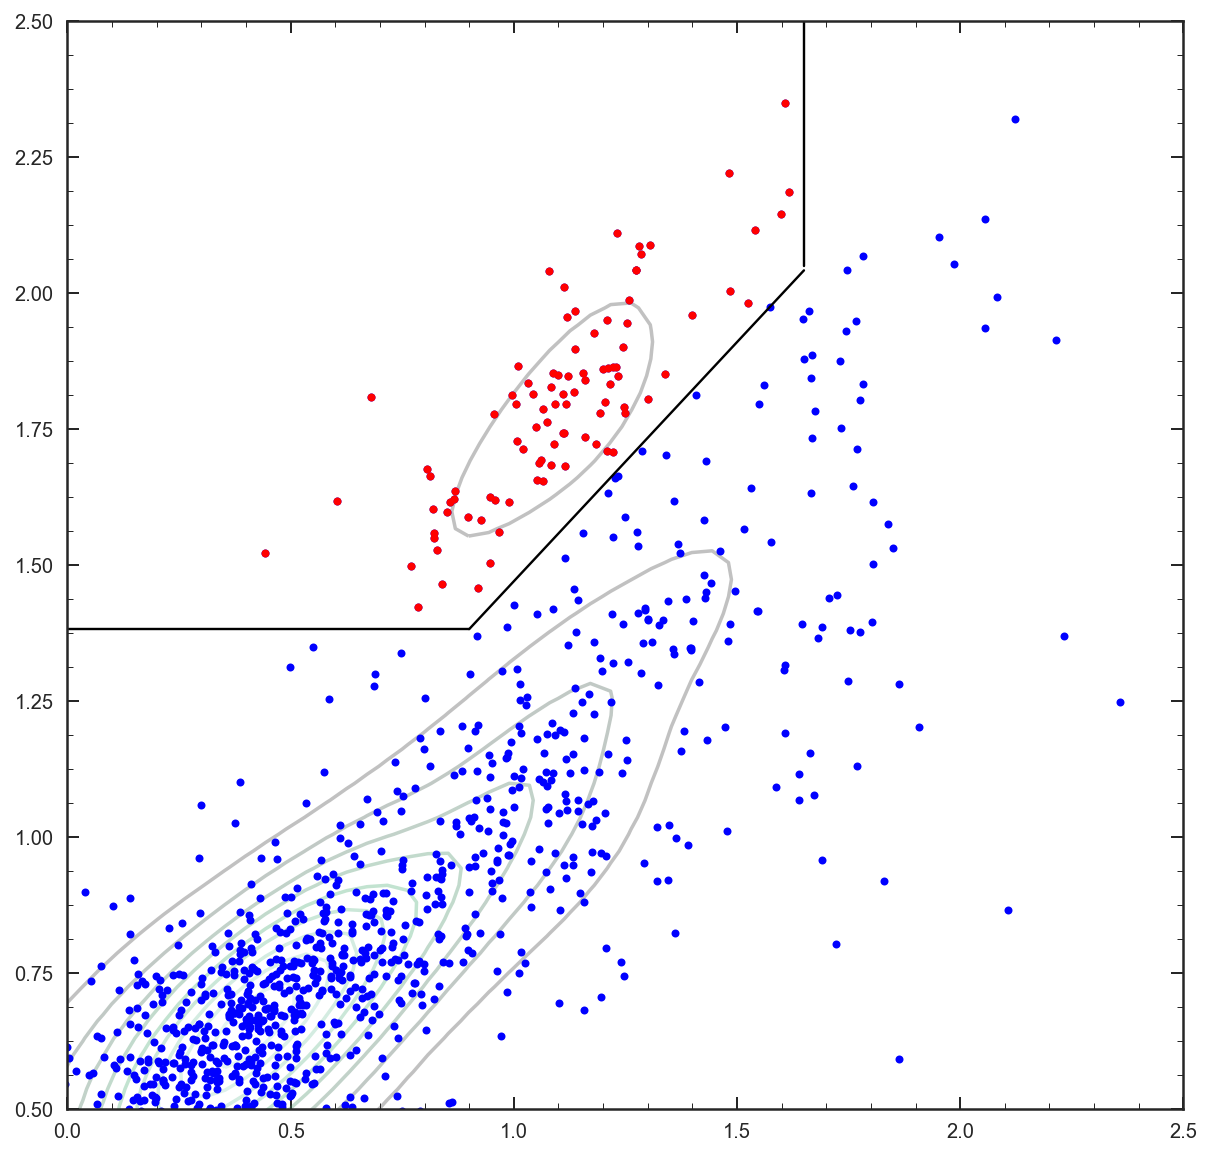

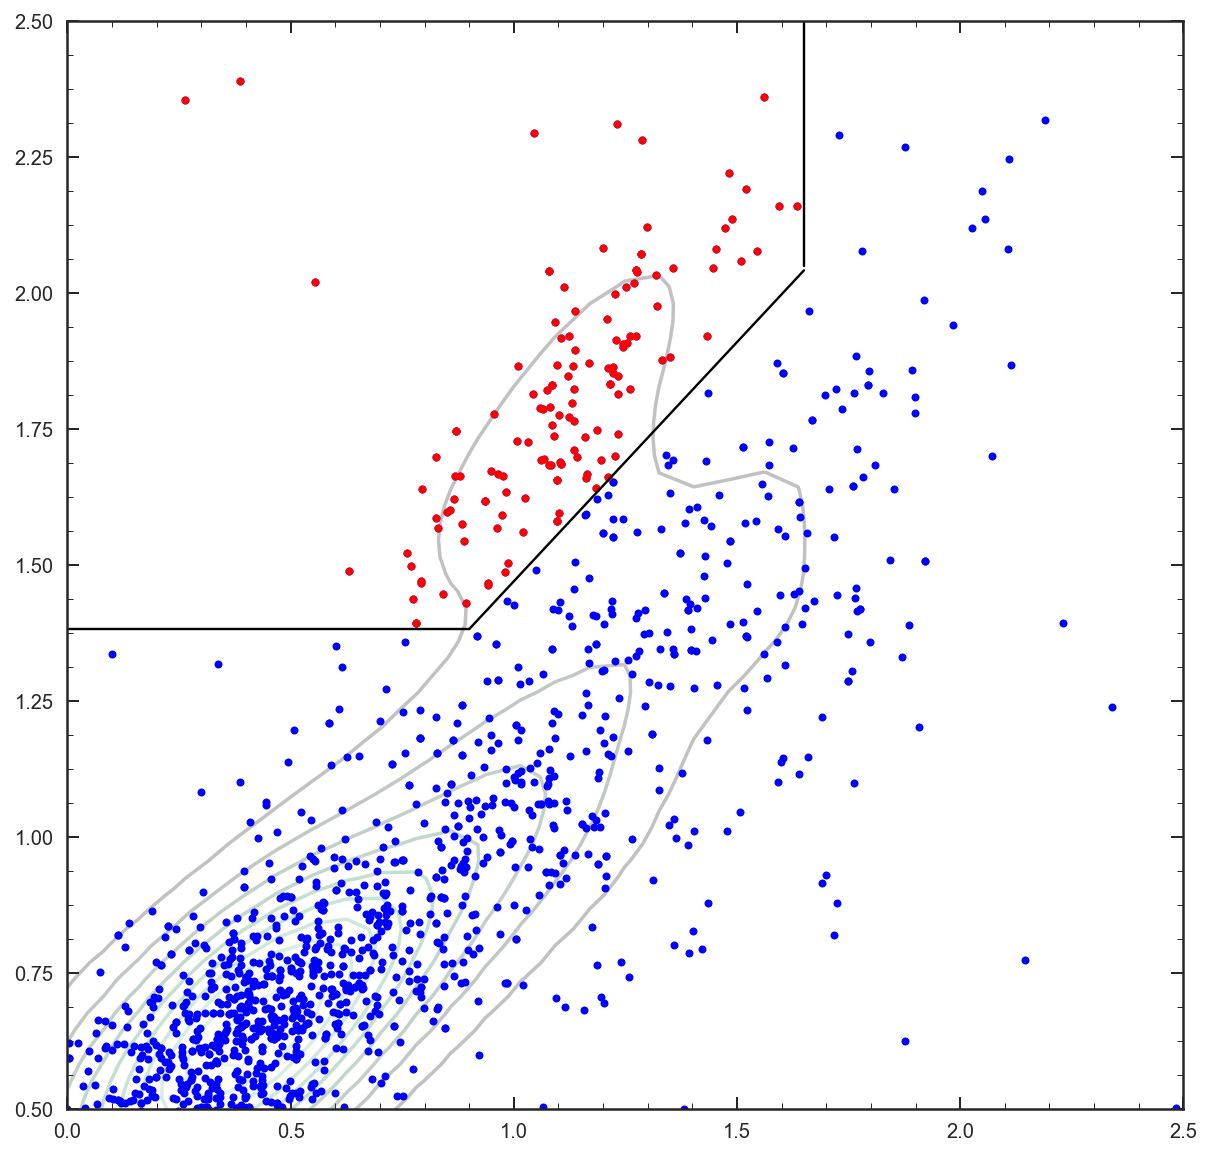

In [109]:
plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ_v4,N_VJ_v4),np.append(S_UV_v4,N_UV_v4),alpha=0.3)

plt.plot(S_VJ_v4, S_UV_v4,'bo',ms=4)
plt.plot(N_VJ_v4, N_UV_v4,'bo',ms=4)

plt.plot(S_VJ_v4[SQ_v4], S_UV_v4[SQ_v4],'ro',ms=4)
plt.plot(N_VJ_v4[NQ_v4], N_UV_v4[NQ_v4],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

#######################

plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ_zg,N_VJ_zg),np.append(S_UV_zg,N_UV_zg),alpha=0.3)

plt.plot(S_VJ_zg, S_UV_zg,'bo',ms=4)
plt.plot(N_VJ_zg, N_UV_zg,'bo',ms=4)

plt.plot(S_VJ_zg[SQ_zg], S_UV_zg[SQ_zg],'ro',ms=4)
plt.plot(N_VJ_zg[NQ_zg], N_UV_zg[NQ_zg],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [121]:
Nid_v4 = N_v4.id[N_VJ_v4[NSF_v4].index].values
Nlmass_v4 = N_v4.lmass[N_VJ_v4[NSF_v4].index].values


In [115]:
NIDS = np.repeat('00000', len(Nid_v4))
for i in range(len(Nid_v4)):
    NIDS[i] = str(Nid_v4[i])
    if len(NIDS[i]) < 5:
        NIDS[i] = '0' + NIDS[i]

In [116]:
rshift = np.zeros(len(NIDS))
OII_f = np.zeros(len(NIDS))
OIII_f = np.zeros(len(NIDS))
Hb_f= np.zeros(len(NIDS))
Ha_f= np.zeros(len(NIDS))


for i in range(len(NIDS)):
    file = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*N*/*/Prep/*{0}.full.fits'.format(NIDS[i]))[0]
    dat = fits.open(file)
    linenums = [U for U in dat[0].header['LINE*']]
    rshift[i] = dat[1].header['Z50']
    for ii in linenums:
        if dat[0].header[ii] == 'OII':
            OII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'OIII':
            OIII_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Hb':
            Hb_f[i] = dat[0].header[ii.replace('LINE','FLUX')]
        if dat[0].header[ii] == 'Ha':
            Ha_f[i] = dat[0].header[ii.replace('LINE','FLUX')]

(8.5, 11.5)

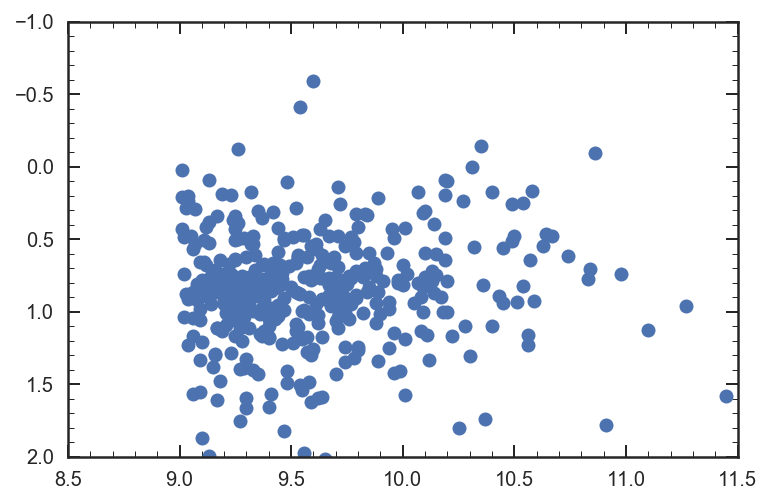

In [126]:
plt.plot(Rmasses,np.log10(R23),'o')
plt.ylim(2,-1)
plt.xlim(8.5,11.5)

In [122]:
R23 = []
Rmasses = []
for i in range(len(Hb_f)):
    if OII_f[i] > 0 and OIII_f[i] > 0 and Hb_f[i] > 0:
        R23.append((OII_f[i] + OIII_f[i]) / Hb_f[i])
        Rmasses.append(Nlmass_v4[i])